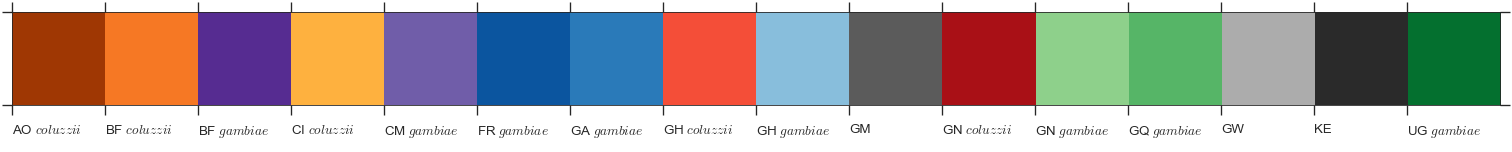

In [22]:
%run data_phase2_ar1.ipynb
# ag1k imports
sys.path.insert(0, '/home/csclarkson/src/python')
from ag1k.util import *
from ag1k import phase2_ar1
from ag1k import phase1_ar3
from ag1k import phase1_ar31

In [23]:
tbl_neaf = (etl
    .fromtsv('/kwiat/vector/ag1000g/release/phase1.AR3/extras/neaf_markers/Neafsey_top_MS_allele_freqs.2.txt')
    .pushheader(['ID', 'chrom', 'pos', 'allele1', 'allele2', 'af_gamb', 'af_colu', 'af_bama'])
    .convert('pos', int)
    .convert((5, 6, 7), float)
    .addfield('allele_gamb', lambda row: row.allele1 if row.af_gamb > row.af_colu else row.allele2)
    .addfield('allele_colu', lambda row: row.allele1 if row.af_gamb < row.af_colu else row.allele2)
)
tbl_neaf

0|ID,1|chrom,2|pos,3|allele1,4|allele2,5|af_gamb,6|af_colu,7|af_bama,8|allele_gamb,9|allele_colu
rs180290715,2L,181564,A,G,0.0294117647058823,1.0,0.970588235294118,G,A
rs180290738,2L,210286,T,G,0.972222188888876,0.0,0.972222188888876,T,G
rs180290751,2L,356421,T,C,1.0,0.0,1.0,T,C
rs180290761,2L,441325,A,C,0.0,1.0,1.0,C,A
rs180290764,2L,456831,T,G,1.0,0.0,1.0,T,G


In [7]:
@functools.lru_cache(maxsize=None)
def compute_aim_gn(chrom):
    
    # extract Neafsey SNP positions
    pos_neaf = tbl_neaf.eq('chrom', chrom).values('pos').array()
    
    # load Ag1000G SNP positions
    pos = allel.SortedIndex(phase2_ar1.callset_pass_biallelic[chrom]['variants/POS'])
    
    # locate intersection
    loc1, loc2 = pos.locate_intersection(pos_neaf)
    
    # find positions of SNPs in intersection
    pos_isec = pos[loc1]
    
    # subselect SNP tables
    tbl_neaf_isec = tbl_neaf.selectin('pos', pos_isec)
    
    callset_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/biallelic/ag1000g.phase2.ar1.pass.biallelic.h5'
    callset = h5py.File(callset_fn, mode='r')
    vtbl_isec = allel.VariantChunkedTable(callset[chrom]['variants'], names=('CHROM', 'POS', 'REF', 'ALT'))
    vtbl_isec = vtbl_isec.compress(loc1)
    # create allele mapping
    ref = vtbl_isec.REF
    alt = vtbl_isec.ALT
    alleles = np.column_stack([tbl_neaf_isec.values('allele_gamb').array(),
                               tbl_neaf_isec.values('allele_colu').array()])
    alleles = alleles[:].astype('|S1')
    mapping = allel.create_allele_mapping(ref, alt, alleles)
    
    # load genotypes
    genotype_isec = allel.GenotypeChunkedArray(phase2_ar1.callset_pass_biallelic[chrom]['calldata/genotype'])
    genotype_isec = genotype_isec.compress(loc1)
    
    # map alleles 
    genotype_aim = genotype_isec.map_alleles(mapping)
    gn_aim = genotype_aim.to_n_alt()
    
    return gn_aim

In [8]:
@functools.lru_cache(maxsize=None)
def compute_aim_genotype_counts(chrom, pop):
    
    gn_aim = compute_aim_gn(chrom)
    
    # extract for population
    gn_aim_pop = gn_aim.take(tbl_samples.eq('population', pop).values('index').list(), axis=1)
    
    # compute genotype counts
    gc = np.column_stack([np.sum(gn_aim_pop == 0, axis=0),
                          np.sum(gn_aim_pop == 1, axis=0),
                          np.sum(gn_aim_pop == 2, axis=0)])

    return gc

In [9]:
def plot_aim_gf(chrom, pop):
    gc = compute_aim_genotype_counts(chrom, pop)
    # sort by coluzzii fraction
    x = 2*gc[:, 2] + gc[:, 1]
    gc = gc[np.argsort(x)]
    # compute genotype frequencies
    gf = gc / gc.sum(axis=1)[:, None]
    
    fig, ax = subplots()
    x = np.arange(gf.shape[0])
    y1 = gf[:, 0]
    y2 = gf[:, 1]
    y3 = gf[:, 2]
    ax.bar(x, y1, width=1, lw=0, color=pop_colours['BFcol'])
    ax.bar(x, y2, width=1, bottom=y1, lw=0, color=pop_colours['GW'])
    ax.bar(x, y3, width=1, bottom=y1+y2, lw=0, color=pop_colours['BFgam'])
    ax.set_xlim(0, gf.shape[0])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1]);

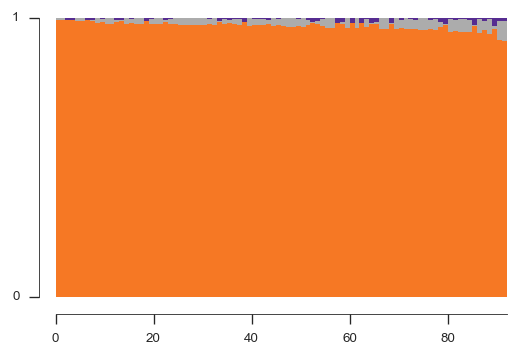

In [13]:
plot_aim_gf('X', 'BFgam')

In [14]:
def plot_aim_gf_allpops(chrom, ax=None, plot=True):
    if ax is None:
        fig, ax = subplots()
        
    xoff = 0
    xoffs = [xoff]
    for pop in populations:
        
        gc = compute_aim_genotype_counts(chrom, pop)
        # sort by coluzzii fraction
        s = 2*gc[:, 2] + gc[:, 1]
        gc = gc[np.argsort(s)]
        # compute genotype frequencies
        gf = gc / gc.sum(axis=1)[:, None]
    
        x = np.arange(gf.shape[0]) + xoff
        y1 = gf[:, 0]
        y2 = gf[:, 1]
        y3 = gf[:, 2]

        if plot:
            ax.bar(x, y1, width=1, lw=0, color=pop_colours['BFcol'])
            ax.bar(x, y2, width=1, bottom=y1, lw=0, color=pop_colours['GW'])
            ax.bar(x, y3, width=1, bottom=y1+y2, lw=0, color=pop_colours['BFgam'])
        
        xoff += gf.shape[0] + 4
        xoffs.append(xoff)

    ax.set_xlim(0, xoff)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])
    return xoffs


In [15]:
def fig_aim(figsize=(3.5, 2), fn_template=None):

    fig = plt.figure(figsize=figsize)

    for i, chrom in enumerate(chromosomes):
        ax = fig.add_subplot(5, 1, i+1)
        if i == 0:
            sns.despine(ax=ax, top=False, bottom=True, offset=0)
        else:
            sns.despine(ax=ax, bottom=True, offset=0)
            ax.set_xticks([])
        xoffs = plot_aim_gf_allpops(chrom, ax=ax, plot=True)
        ax.set_yticks([.5])
        ax.set_ylim(0, 1)
        ax.set_yticklabels([chrom], va='center', ha='right')
        ax.yaxis.set_tick_params(length=0, pad=0)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i == 0:
            # legend
            handles = list()
            patch = mpl.patches.Patch(color=pop_colours['BFcol'], label='$An.\ gambiae$')
            handles.append(patch)
            patch = mpl.patches.Patch(color=pop_colours['BFgam'], label='$An.\ coluzzii$')
            handles.append(patch)
            patch = mpl.patches.Patch(color=pop_colours['GW'], label='hybrid')
            handles.append(patch)
            ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1), title='AIM genotype')
            # xticks
            xoffs = np.array(xoffs)
            xticks = ((xoffs[:-1] + xoffs[1:]) / 2) - 10
            ax.set_xticks(xticks)
            ax.set_xticklabels([pop_labels[p] for p in populations], rotation=45, ha='left', va='bottom')
            ax.xaxis.set_tick_params(length=0, pad=0)
            
    if fn_template:
        for dpi in 120, 300, 900:
            fn = fn_template.format(size=('x'.join(map(str, figsize))), dpi=dpi)
            fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')

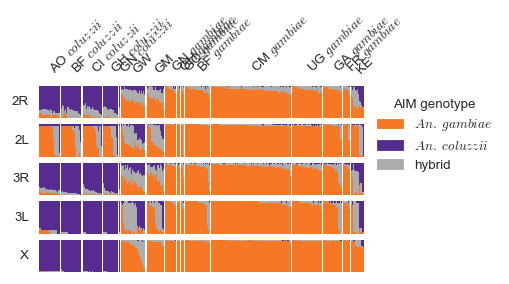

In [16]:
fn_template = '/data/coluzzi/ag1000g/data/paper1/artwork/aim.{size}.{dpi}.jpeg'
fig_aim()

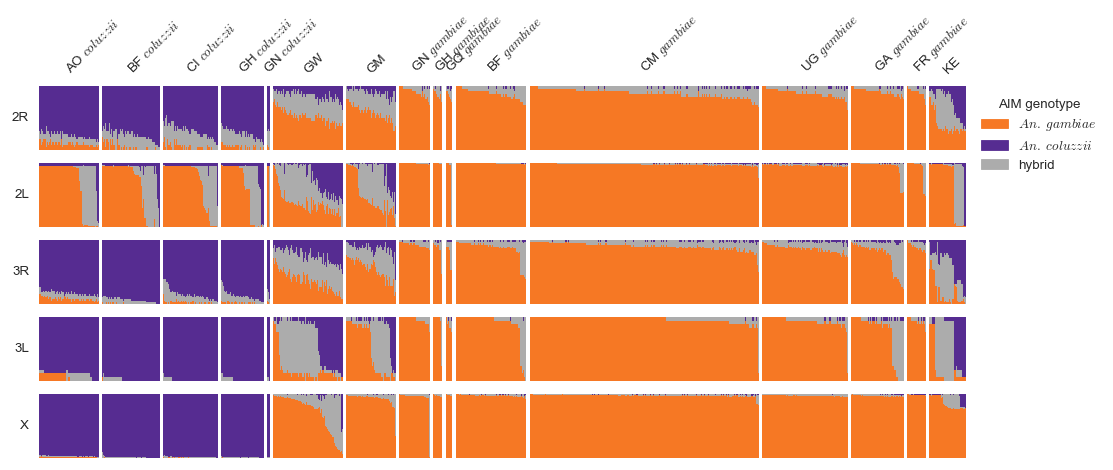

In [21]:
fn_template = '/home/csclarkson/aim.{size}.{dpi}.jpeg'
fig_aim(fn_template=fn_template, figsize=(10,4))